<a href="https://colab.research.google.com/github/ShubhikaVerma/-Energy-Consumptions-Dashboard/blob/main/RLipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import random

# Fix random seeds for reproducibility
np.random.seed(42)
random.seed(42)

class EvacuationEnv:
    def __init__(self, people=20, max_steps=100):
        self.people = people
        self.max_steps = max_steps
        self.num_zones = 4
        self.reset()

    def reset(self):
        """Reset environment at start of each episode"""
        self.remaining = self.people
        self.step_count = 0
        self.exitA_open = 1
        self.exitB_open = 1

        # Fixed initial distribution (deterministic instead of random multinomial)
        self.zones = np.array([self.people//self.num_zones] * self.num_zones)
        self.queueA = 0
        self.queueB = 0

        return self._get_state()

    def _get_state(self):
        """Return normalized state vector"""
        zone_frac = self.zones / self.people
        return np.concatenate([
            zone_frac,
            [self.queueA/self.people],
            [self.queueB/self.people],
            [self.exitA_open, self.exitB_open],
            [self.remaining/self.people]
        ])

    def step(self, action):
        """
        Actions:
        0 = Direct to Exit A
        1 = Direct to Exit B
        2 = Issue Congestion Warning
        3 = No Action
        """
        self.step_count += 1
        evac = 0
        reward = 0

        # Deterministic evacuation rate: always 1 person exits if action is valid
        if action == 0 and self.exitA_open and self.remaining > 0:
            evac = 1
            self.queueA += evac
        elif action == 1 and self.exitB_open and self.remaining > 0:
            evac = 1
            self.queueB += evac
        elif action == 2:
            reward += 0.1  # small reward for warning (encourages dispersion)

        # Update remaining people
        self.remaining = max(0, self.remaining - evac)

        # Congestion penalty if any queue > 40% of population
        if self.queueA > self.people * 0.4 or self.queueB > self.people * 0.4:
            reward -= 1.0

        # Success or failure check
        done = False
        if self.remaining == 0:
            reward += 10
            done = True
        elif self.step_count >= self.max_steps:
            reward -= 5
            done = True
        else:
            reward += 0.2 * evac - 0.01  # reward for each evac, time penalty

        # Deterministic hazard: Exit A blocked after 50 steps
        if self.step_count == 50:
            self.exitA_open = 0
        if self.step_count == 70:
            self.exitA_open = 1  # reopen after 20 steps

        return self._get_state(), reward, done


Stable Success Rate: 100.00%


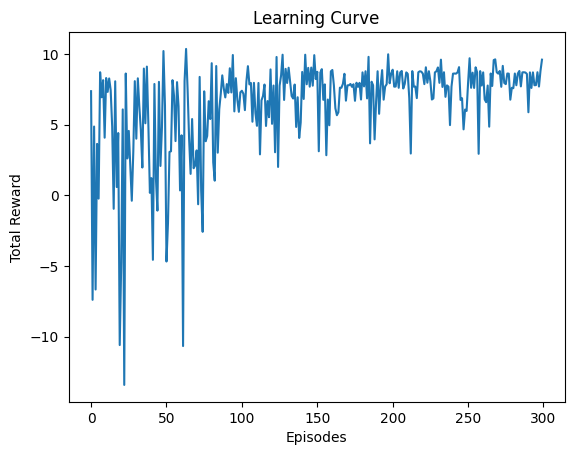

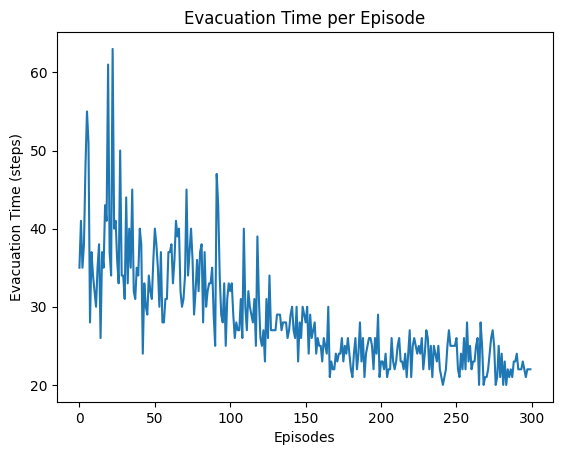

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# --- Discretization helper ---
def discretize_state(state, bins=10):
    """Discretize continuous state values into integers (for Q-table indexing)"""
    return tuple((state * bins).astype(int))

# --- Q-learning parameters ---
alpha = 0.1      # learning rate
gamma = 0.95     # discount factor
epsilon = 1.0    # exploration rate
epsilon_min = 0.05
epsilon_decay = 0.995
episodes = 300   # number of training episodes

# Q-table as a dictionary (for flexible state indexing)
Q = {}

# --- Metrics ---
rewards_per_episode = []
evacuation_times = []
success_flags = []

# --- Training loop ---
env = EvacuationEnv()

for ep in range(episodes):
    state = env.reset()
    state_disc = discretize_state(state)
    total_reward = 0
    done = False

    while not done:
        # Ensure state exists in Q-table
        if state_disc not in Q:
            Q[state_disc] = np.zeros(4)  # 4 actions

        # Choose action (ε-greedy)
        if np.random.rand() < epsilon:
            action = np.random.randint(0, 4)  # explore
        else:
            action = np.argmax(Q[state_disc])  # exploit

        # Take action
        next_state, reward, done = env.step(action)
        next_state_disc = discretize_state(next_state)

        if next_state_disc not in Q:
            Q[next_state_disc] = np.zeros(4)

        # Q-learning update
        best_next = np.max(Q[next_state_disc])
        Q[state_disc][action] += alpha * (reward + gamma * best_next - Q[state_disc][action])

        # Move to next state
        state_disc = next_state_disc
        total_reward += reward

    # Metrics per episode
    rewards_per_episode.append(total_reward)
    evacuation_times.append(env.step_count)
    success_flags.append(env.remaining == 0)

    # Decay exploration
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

# --- Results ---
success_rate = sum(success_flags) / len(success_flags)
print(f"Stable Success Rate: {success_rate*100:.2f}%")

# Learning curve
plt.plot(rewards_per_episode)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Learning Curve")
plt.show()

# Evacuation times
plt.plot(evacuation_times)
plt.xlabel("Episodes")
plt.ylabel("Evacuation Time (steps)")
plt.title("Evacuation Time per Episode")
plt.show()
